<a href="https://colab.research.google.com/github/noreallyimfine/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=180.18849314523848, mobile=False), User(purchased=True, time_on_site=135.67700482149365, mobile=False), User(purchased=True, time_on_site=159.88535379510446, mobile=True), User(purchased=True, time_on_site=257.7835981679507, mobile=True), User(purchased=False, time_on_site=86.99445445027507, mobile=False), User(purchased=False, time_on_site=173.67358829592212, mobile=True), User(purchased=True, time_on_site=44.968058188901246, mobile=True), User(purchased=False, time_on_site=30.15219480121866, mobile=True), User(purchased=False, time_on_site=460.0007745853941, mobile=False), User(purchased=False, time_on_site=122.22911474525455, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,180.188493,False
1,True,135.677005,False
2,True,159.885354,True
3,True,257.783598,True
4,False,86.994454,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.395806383057993,5.457727420381445,6.012980358659168,6.370819673044487,6.526220869482321,6.618506115477453,6.744300972093091,6.937814523764514,7.022230321283178,7.738183255456649,...,570.7205763776294,572.579212329361,573.071762294419,577.5607756708825,578.0265919014007,578.8349054472059,584.0914381586123,586.960469433746,588.7975083689481,599.8083961016524
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,0,1,1
True,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,240,233,105,29,28
True,96,131,102,20,16


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,0.714286,0.64011,0.507246,0.591837,0.636364
True,0.285714,0.35989,0.492754,0.408163,0.363636


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.622667
True,0.328,0.377333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [1]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

!pip install pandas==0.23.4

     |████████████████████████████████| 8.9MB 4.9MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 0.23.4 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [85]:
import pandas as pd

# Load are data using raw file, setting the first column as the index
persons = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', index_col=0)
# Check that it looks right
persons.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [86]:
# Check out the shape
persons.shape

(1200, 3)

In [87]:
# Lets get some summary statistics
persons.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [0]:
# Create a crosstab, see we need some binning
pd.crosstab(persons['exercise_time'], persons['weight'])

In [0]:
# Put all our attributes into bins to get better info 
exercise_bins = pd.cut(persons['exercise_time'], 6)
weight_bins = pd.cut(persons['weight'], 6)
age_bins = pd.cut(persons['age'], 5)

In [90]:
# Check out our crosstabs with normalization - alot of the data still not really informative 
# But we do see a huge dropoff when we look at higher exercise times for higher weight bins
pd.crosstab(exercise_bins, weight_bins, normalize='index')

weight,"(99.854, 124.333]","(124.333, 148.667]","(148.667, 173.0]","(173.0, 197.333]","(197.333, 221.667]","(221.667, 246.0]"
exercise_time,,,,,,
"(-0.3, 50.0]",0.141079,0.153527,0.153527,0.195021,0.215768,0.141079
"(50.0, 100.0]",0.159091,0.178030,0.238636,0.170455,0.234848,0.018939
"(100.0, 150.0]",0.262887,0.139175,0.252577,0.211340,0.134021,0.000000
"(150.0, 200.0]",0.268421,0.326316,0.231579,0.163158,0.010526,0.000000
"(200.0, 250.0]",0.296774,0.406452,0.270968,0.025806,0.000000,0.000000
"(250.0, 300.0]",0.448718,0.435897,0.115385,0.000000,0.000000,0.000000


In [91]:
# Now lets add in age
ct = pd.crosstab(age_bins, [weight_bins, exercise_bins], normalize='columns')
ct

weight         (99.854, 124.333]       ...        (221.667, 246.0]
exercise_time       (-0.3, 50.0]       ...           (50.0, 100.0]
age                                    ...                        
(17.938, 30.4]          0.176471       ...                     0.0
(30.4, 42.8]            0.176471       ...                     0.0
(42.8, 55.2]            0.147059       ...                     0.0
(55.2, 67.6]            0.117647       ...                     0.0
(67.6, 80.0]            0.382353       ...                     1.0

[5 rows x 29 columns]

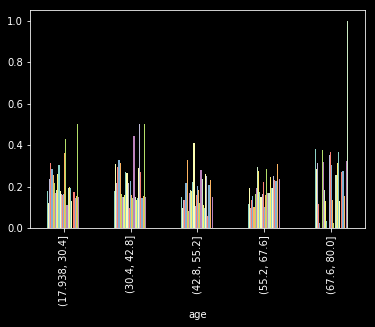

In [92]:
# A busy uninformative plot
ct.plot(kind='bar', legend=False);

In [93]:
# OK - still not getting too much info
# let check out some subsets of our data

# Here we break our data on the line of 50yrs old and 200 minutes of exercise
ct_age50_et200 = pd.crosstab((persons['age'] > 50), (persons['exercise_time'] > 200))
ct_age50_et200

exercise_time,False,True
age,,
False,419,220
True,470,91


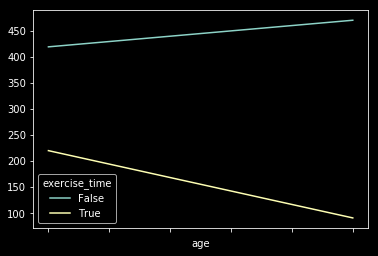

In [94]:
# Here we plot and see an inverse correlation between age and exercise time 
ct_age50_et200.plot();

In [95]:
# Normalized to get an immediate sense  
ct_age50_et200_normalized = pd.crosstab((persons['age'] > 50), (persons['exercise_time'] > 200), normalize='index')
ct_age50_et200_normalized

# 200 was too high a point to choose... 65% of younger people dont exercise that much

exercise_time,False,True
age,,
False,0.655712,0.344288
True,0.837790,0.162210


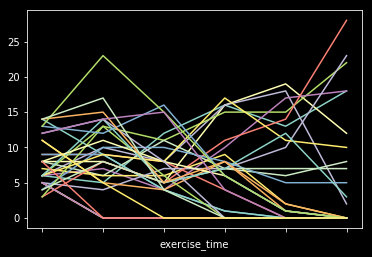

In [96]:
# Lets see how weight confounds this

pd.crosstab(exercise_bins, [age_bins, weight_bins]).plot(legend=False);

# Too much going on to tell

In [97]:
# Lets try splitting up our weight like we did age and exercise time

# Splitting everything near the middle of the dataset
ct_weight175_age50_et150 = pd.crosstab((persons['weight'] > 175), [(persons['age'] > 50), (persons['exercise_time'] > 150)], normalize='columns')
ct_weight175_age50_et150

# This shows a stark dropoff in exercise time for people over 175lbs, regardless of age
# Whereas, regardless of age, those under 175 split near 50/50 who exercised >150min/week
# Those over 175lbs almost uniformly did not exercise alot

### CAN WE FIGURE OUT WHICH IS THE CHICKEN AND WHICH IS THE EGG???

age               False               True           
exercise_time     False     True      False     True 
weight                                               
False          0.577558  0.940476  0.563131  0.915152
True           0.422442  0.059524  0.436869  0.084848

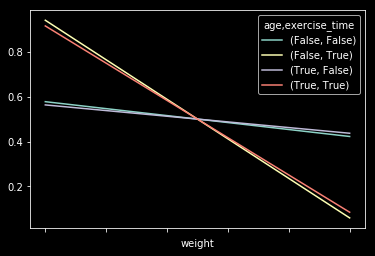

In [98]:
ct_weight175_age50_et150.plot()

In [107]:
# Re-bin to create a split in data near middle of each without bool comparison

exercise_bins = pd.cut(persons['exercise_time'], 2)
weight_bins = pd.cut(persons['weight'], 2)
age_bins = pd.cut(persons['age'], 2)

# Make crosstab of the bins
ct_two_bin = pd.crosstab(weight_bins, [age_bins, exercise_bins], normalize='columns')
ct_two_bin

age             (17.938, 49.0]      ...         (49.0, 80.0]
exercise_time    (-0.3, 150.0]      ...       (150.0, 300.0]
weight                              ...                     
(99.854, 173.0]       0.560403      ...             0.895954
(173.0, 246.0]        0.439597      ...             0.104046

[2 rows x 4 columns]

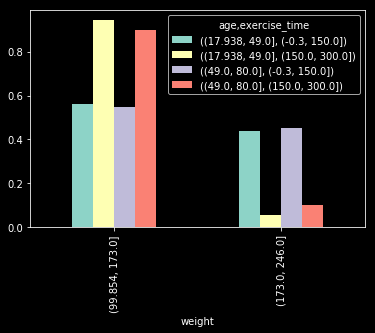

In [100]:
# Barplot - again we see nearly all the high exercise times disappear when weight gets up there
ct_two_bin.plot.bar()

In [0]:
import seaborn as sns

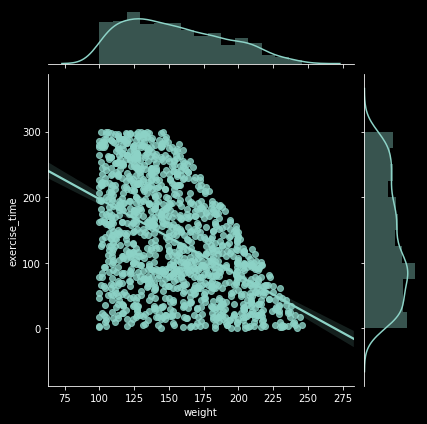

In [116]:
# Played with seaborn, tried all the different kinds of jointplots
sns.jointplot(persons['weight'], persons['exercise_time'], kind='reg')

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background') 

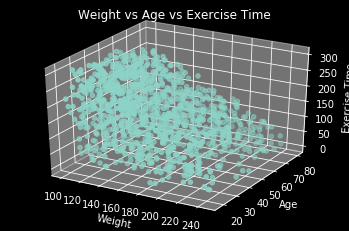

In [121]:
# 3D PLOTTING!!!
from mpl_toolkits.mplot3d import Axes3D

# Wish I understood these two lines right here.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(persons['weight'], persons['age'], persons['exercise_time'])
ax.set_xlabel('Weight')
ax.set_ylabel('Age')
ax.set_zlabel('Exercise Time')
ax.set_title('Weight vs Age vs Exercise Time');

 ### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


1. The variables are all discrete, ordinal values

2. I found weight to be highly correlated with exercise time. 

3. Age was a spurious variable, not meaningfully affecting weight or exercise time

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

This is my spurious correlation

http://tylervigen.com/view_correlation?id=34850